In [1]:
pip install pymc arviz matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
# ─── 1. LOAD DATA FROM EXCEL ────────────────────────────────────────────────────
# 1) Telling pandas “there is no header row” so every row is data, and columns get numeric names 0,1,2,...
data = pd.read_excel(
    '/users/me/bt/pushpdeept22/Downloads/data_reactor/500 ml/SDS/0.1 wt %/NO PACK/nopack_0.1wt_sds_r1.xlsx',
    sheet_name=0,
    header=None
)

# 2) Pressure and Time
pressure_kPa = data[6]
time_s       = data[8]

# 3) Drop the rows that failed to parse as numbers
mask = pressure_kPa.notna() & time_s.notna()
pressure_kPa = pressure_kPa[mask].astype(float)
time_s       = time_s[mask].astype(float)

# 4) Units conversion
Pe_full = pressure_kPa.to_numpy() / 10.0     # → MPa
t_full  = time_s.to_numpy()       / 3600.0  # → hours

# Quick check
print("Pe_full (MPa):", Pe_full[:5])
print("t_full  (h) :", t_full[:5])

Pe_full (MPa): [7.446241 7.425357 7.408342 7.395211 7.385381]
t_full  (h) : [0.         0.00111111 0.00222222 0.00333333 0.00444444]


In [3]:
# ─── 2. CONSTANTS & THERMODYNAMIC PREP ─────────────────────────────────────────
Ar = np.pi * (0.075 ** 2) / 4
R  = 8.314

# peter atkins - physical chemistry
# Introduction to chemical engineering thermodynamics by J.M. Smith - page - 650+
Tc, Pc, w, T = 190.6, 4.599, 0.012, 274.15
Tr = T / Tc

# compressibility factor z (Pitzer)
a = (0.083 - 0.422*(Tc/T)**1.6)*(Tc/Pc)
b = w*(0.139 - 0.172*(Tc/T)**4.2)*(Tc/Pc)
z = 1 + a*(Pe_full/T) + b*(Pe_full/T)

# experimental moles (nexp)
v = 0.3674640599
n_water = 7.334773592
nd    = 5.75
nexp = ((7500000)/(0.828026351079252) - (Pe_full*1e6)/(z))*(v/(R*T)) # here nexp is in millimoles
nexp_full = ((nexp/n_water)*nd)/10

# fugacity coefficent & potentials (hydrate & liquid)
# pengrobinson eqn
m     = 0.37464 + 1.54226*w - 0.26992*w**2
alfa  = (m*(1 - np.sqrt(Tr)))**2
arel  = ((0.45724*(R*Tc)**2)/((Pc)*alfa))
brel  = 0.0778*R*Tc/(Pc)
A     = arel*(Pe_full)/(R*T)**2
B     = brel*(Pe_full)/(R*T)
fh    = np.exp(z - 1 - np.log(z - B)
             - A/(2*np.sqrt(2*B))
             * np.log((z+(1+np.sqrt(2))*B)/(z+(1-np.sqrt(2))*B)))
fg    = fh * Pe_full

# adsorption term (van der Waals p-model)
AsmL, BsmL = 3.7237e3, 2.7088e-3
Alar, Blar = 1.8372e2, 2.7379e-3
Csmall     = (AsmL/T)*np.exp(BsmL/T)
Clarge     = (Alar/T)*np.exp(Blar/T)
hydrate_pot      = (1/23)*np.log(1 + (Csmall*fg)) + (3/23)*np.log(1 + (Clarge*fg))

# thermochemical term
muo   = 1120
fterm = muo/(R*273.15)
#enthalpy = (
 #   -4297*(1/273.15 - 1/T)
  #  - 34.583*(np.log(T/273.15) + 273.15/T - 1)
   # + 0.189*(
    #    273.15*(np.log(273.15)-np.log(T))
     #   + (273.15**2)/(2*T + T/2 - 273.15)
#    )
#)
enthalpy = (1/8.314)*(np.log(T/273.15)*(-34.583 - 0.189*273.15) + (T - 273.15)*(0.189/2 + (0.189/2)*(273.15/T) + 34.583/T - 4297/(T*273.15)))
volume = (4.5959e-6*Pe_full*1e6)/(R*273.15)
gamma  = 1
xw     = (
    1
    - fg*np.exp(-15.8262 + 1559.0631/T)
         * np.exp(-(32*(Pe_full*9.86923 - 1))/(82.06*T))
)
liquid_pot = fterm - enthalpy + volume - np.log(xw*gamma)

# ΔF and RT_fit
DF_full = liquid_pot - hydrate_pot
RT_fit  = R * 274.15

In [4]:
# ─── 3. SPLIT TRAIN/TEST ────────────────────────────────────────────
np.random.seed(0)
N = len(nexp_full)
idx = np.random.permutation(N)
n_train = int(0.8 * N)
train_idx, test_idx = idx[:n_train], idx[n_train:]

t_train, DF_train, y_train = (
    t_full[train_idx], DF_full[train_idx], nexp_full[train_idx]
)
t_test, DF_test, y_test = (
    t_full[test_idx], DF_full[test_idx], nexp_full[test_idx]
)


In [5]:
# ─── 4. FULL BAYESIAN MODEL (ADVI warm‑start + NUTS) ────────────────
with pm.Model() as bayes_model:

    # 4a. STANDARDIZE & WRAP DATA
    t_mean,  t_std  = t_train.mean(),  t_train.std()
    DF_mean, DF_std = DF_train.mean(), DF_train.std()
    t_s  = pm.Data("t_s",  (t_train - t_mean)  / t_std)
    DF_s = pm.Data("DF_s", (DF_train - DF_mean) / DF_std)

    # 4b. PRIORS (stable parameterization)
    p     = pm.Beta("p",   alpha=2, beta=2)
    s     = pm.Beta("s",   alpha=2, beta=2)
    log_q = pm.Normal("log_q", mu=np.log(5000),  sigma=1)
    log_r = pm.Normal("log_r", mu=np.log(20000), sigma=1)
    q = pm.Deterministic("q", pm.math.exp(log_q))
    r = pm.Deterministic("r", pm.math.exp(log_r))
    sigma = pm.HalfNormal("sigma", sigma=5)

    # 4c. VECTORIZED FORWARD MODEL
    expo = pm.math.exp(-r / RT_fit)
    rate = (
        nd * q * expo * (s / RT_fit) * Ar
      * (DF_s * DF_std + DF_mean)
      * (t_s  * t_std  + t_mean)
      * 3600
    )
    y_est = (p / nd) * (1 - pm.math.exp(-rate)) * nd * 100

    # 4d. LIKELIHOOD
    pm.Normal("Y_obs", mu=y_est, sigma=sigma, observed=y_train)

    # 4e. ADVI warm‑start
    advi_fit = pm.fit(
        method="fullrank_advi",
        n=20000,
        obj_optimizer=pm.adam(learning_rate=0.01),
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)]
    )

    advi_idata = advi_fit.sample(1)
    posterior = advi_idata.posterior
    
    # pick first chain, first draw
    first = posterior.isel(chain=0, draw=0)
    
    # get free RV names from the model
    rv_names = [rv.name for rv in bayes_model.free_RVs]
    
    # build a start dict with numpy scalars
    start_map = {}
    for var in rv_names:
        if var in first.data_vars:
            val = first[var].values
            start_map[var] = np.asarray(val).squeeze()
        else:
            start_map[var] = 0.0
    
    # create one init dict per chain; add tiny jitter so chains don't start identical
    import numpy as np
    n_chains = 4
    start_list = []
    for i in range(n_chains):
        jitter = {k: (float(v) + np.random.normal(scale=1e-6))
                  for k, v in start_map.items()}
        start_list.append(jitter)
    
    with bayes_model:
        trace = pm.sample(
            draws=1300,
            tune=700,
            chains=n_chains,
            cores=4,
            initvals=start_list,
            target_accept=0.95,
            max_treedepth=12,
            return_inferencedata=True
        )


Output()

Finished [100%]: Average Loss = 7,858.1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, s, log_q, log_r, sigma]


Output()

Sampling 4 chains for 700 tune and 1_300 draw iterations (2_800 + 5_200 draws total) took 1015 seconds.


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
           mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p         0.700     0.000     0.699      0.701      0.000    0.000    3806.0   
q      8506.721  9493.622   590.166  23471.520    188.101  476.162    2655.0   
r      6898.314  2225.292  2464.773  10844.946     46.306   33.010    2277.0   
s         0.527     0.213     0.140      0.899      0.004    0.002    3598.0   
sigma     2.333     0.028     2.278      2.381      0.000    0.000    3867.0   

       ess_tail  r_hat  
p        3075.0    1.0  
q        2447.0    1.0  
r        2268.0    1.0  
s        2944.0    1.0  
sigma    3016.0    1.0  


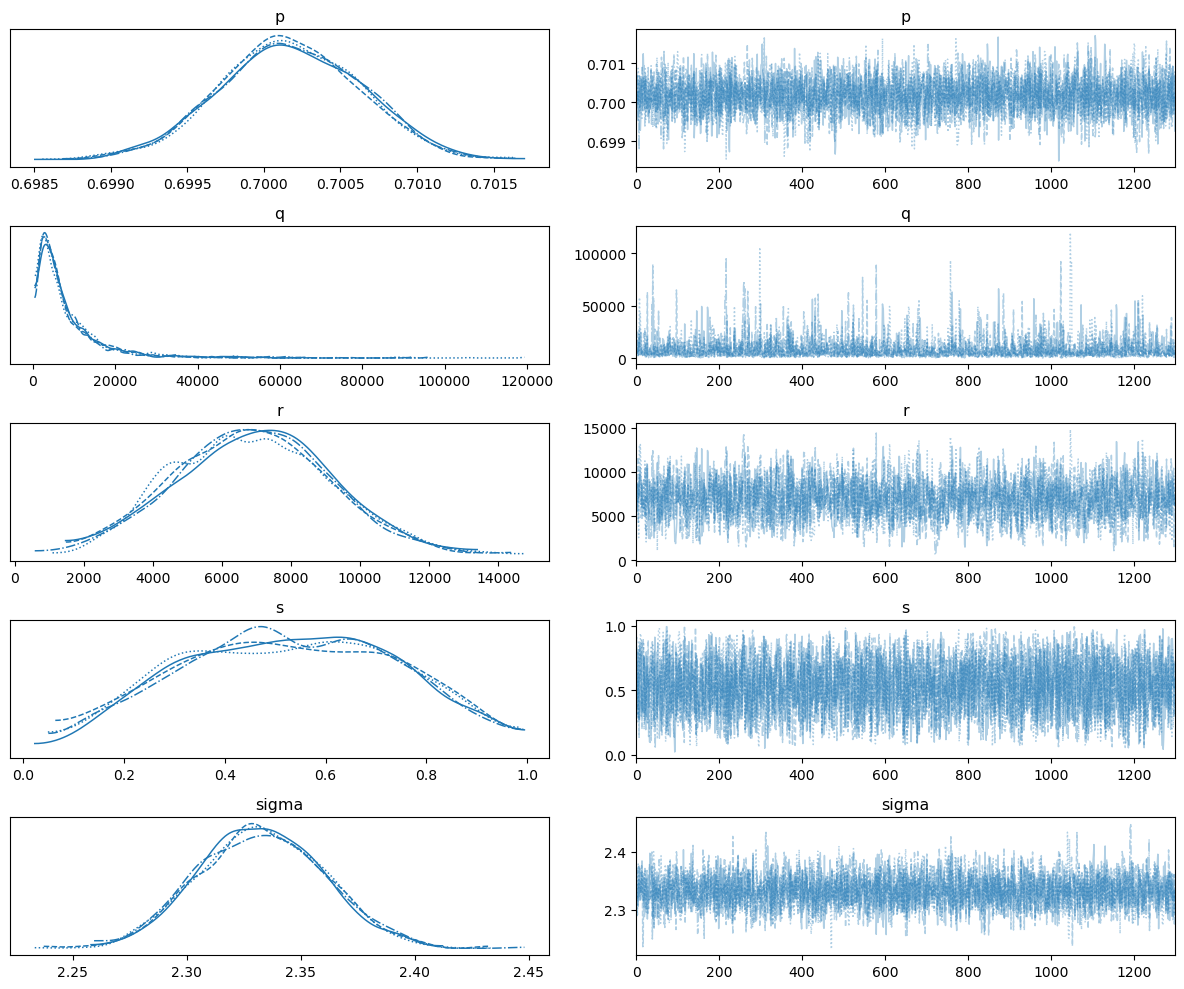

In [6]:
# ─── 5. POSTERIOR SUMMARY & TRACES ─────────────────────────────────
var_extended = ["p","q","r","s","sigma"]
print(az.summary(trace, var_names=["p","q","r","s","sigma"]))
az.plot_trace(trace, var_names=["p","q","r","s","sigma"])
plt.tight_layout()
plt.show()

Sampling: [Y_obs]


Output()

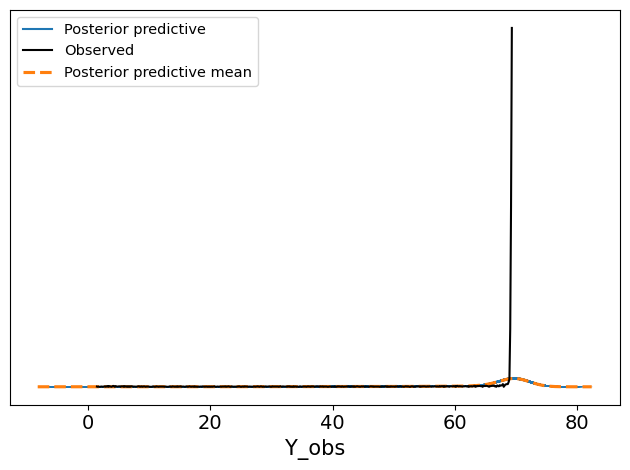

In [8]:
# ─── 6. POSTERIOR PREDICTIVE CHECK (direct InferenceData) ────────────────────
with bayes_model:
    ppc_idata = pm.sample_posterior_predictive(
        trace,
        var_names=["Y_obs"],
        return_inferencedata=True
    )
az.plot_ppc(ppc_idata, data_pairs={"Y_obs": "Y_obs"})
plt.tight_layout()
plt.show()

In [9]:
# ─── 7. Finding Predictions on test data ────────────────────
# 1) Extract *scalar* posterior means
post = trace.posterior.mean(dim=("chain","draw"))
means = {v: post[v].item() for v in ["p","q","r","s","sigma"]}

# 2) New predict function using raw + alpha
def predict_np(p, q, r, s, DF, t):
    expo = np.exp(-r / RT_fit)
    return (p/nd)*(1-np.exp(-nd*q*expo*(s/RT_fit)*Ar*DF*t*3600))*nd*100

# 3) Compute predictions on test set
y_pred_test = predict_np(
    means["p"], means["q"], means["r"], means["s"],
    DF_test, t_test
)

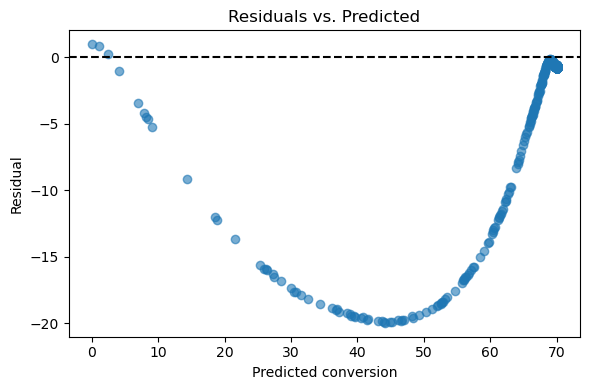

In [10]:
# ─── 8. RESIDUAL PLOT ────────────────────────────────────────────────────────────
res = y_test - y_pred_test
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, res, alpha=0.6)
plt.axhline(0, color='k', ls='--')
plt.xlabel('Predicted conversion')
plt.ylabel('Residual')
plt.title('Residuals vs. Predicted')
plt.tight_layout()
plt.show()

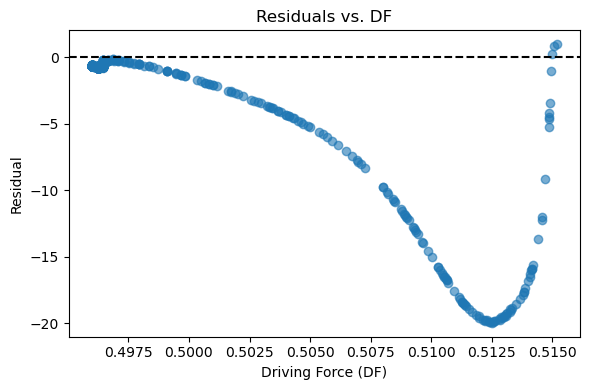

In [11]:
res = y_test - y_pred_test
plt.figure(figsize=(6,4))
plt.scatter(DF_test, res, alpha=0.6)
plt.axhline(0, color='k', ls='--')
plt.xlabel('Driving Force (DF)')
plt.ylabel('Residual')
plt.title('Residuals vs. DF')
plt.tight_layout()
plt.show()

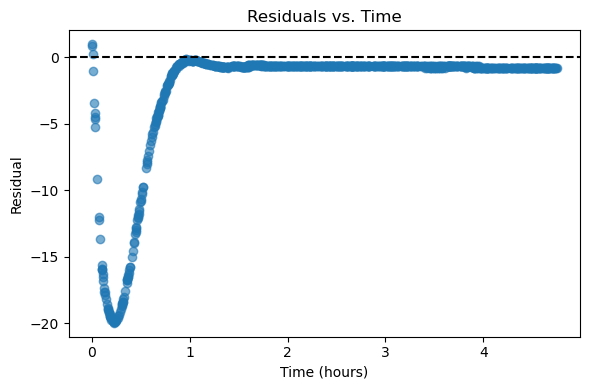

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(t_test, res, alpha=0.6)
plt.axhline(0, color='k', ls='--')
plt.xlabel('Time (hours)')
plt.ylabel('Residual')
plt.title('Residuals vs. Time')
plt.tight_layout()
plt.show()

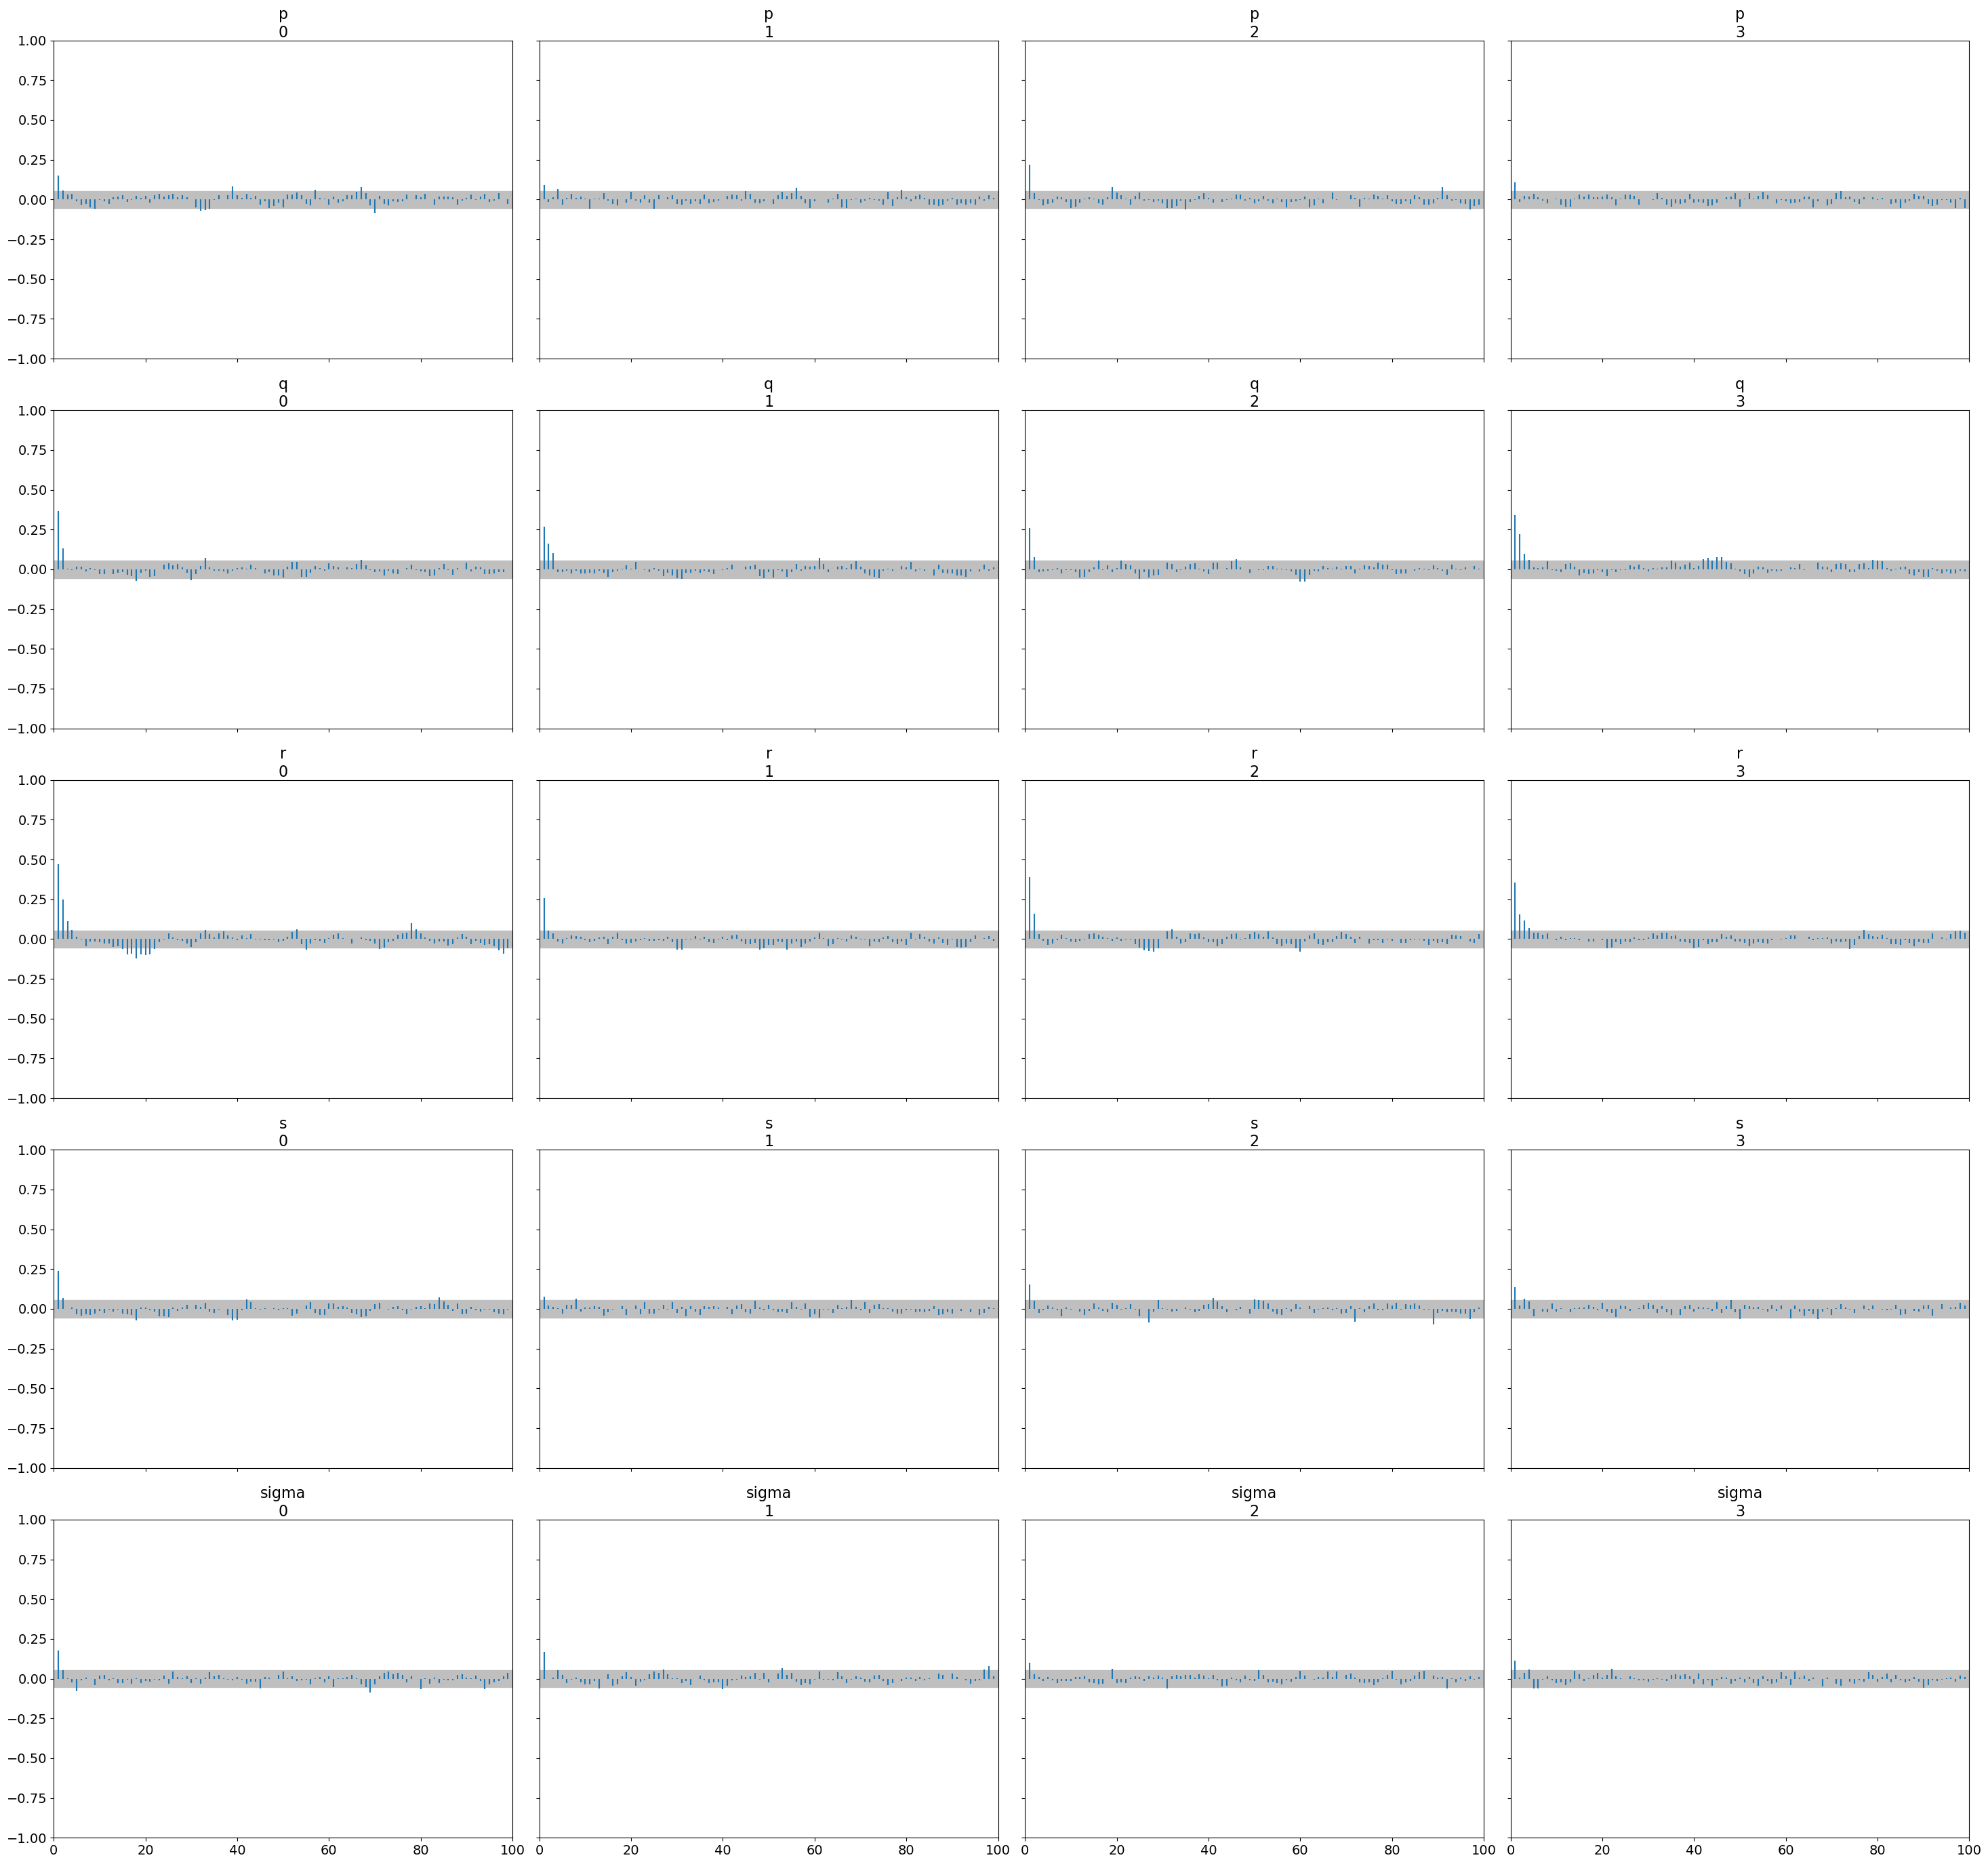

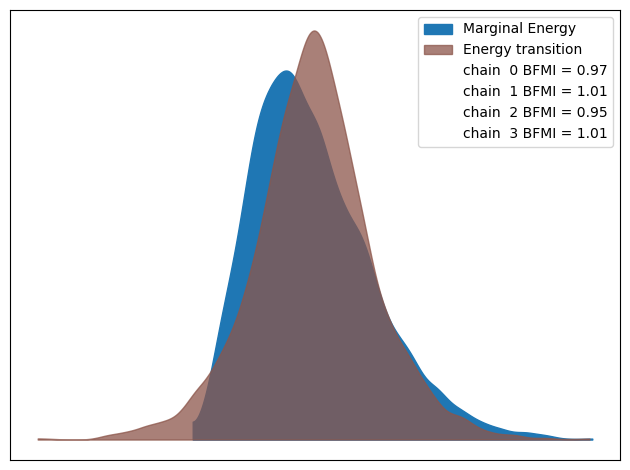

In [13]:
# ─── 9. AUTOCORR & ENERGY DIAGNOSTICS ────────────────────────────────────────
az.plot_autocorr(trace, var_names=var_extended)
plt.tight_layout()
plt.show()

az.plot_energy(trace)
plt.tight_layout()
plt.show()

In [14]:
# ─── 10. TEST‑SET PREDICTION & METRICS ──────────────────────────────
def predict_np(p, q, r, s, DF, t):
    expo = np.exp(-r / RT_fit)
    return (p/nd)*(1-np.exp(-nd*q*expo*(s/RT_fit)*Ar*DF*t*3600))*nd*100

means = {v: trace.posterior[v].mean().item() for v in ["p","q","r","s"]}
y_pred = predict_np(means["p"], means["q"], means["r"], means["s"],
                    DF_test, t_test)

# ─── 8. TEST-SET METRICS ───────────────────────────────────────────────────────
mse   = lambda y, y_pred: np.mean((y - y_pred)**2)
rmse  = lambda y, y_pred: np.sqrt(mse(y, y_pred))

def r2(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

epsilon = 1e-6

acc = lambda y_true, y_pred: 100 - np.mean(
    np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-3, 1e-3, y_true))
) * 100

print(f"Test RMSE = {rmse(y_test, y_pred):.4f}")
print(f"Test R²   = {r2(y_test, y_pred):.4f}")
print(f"Test Acc  = {acc(y_test, y_pred):.2f}%")


Test RMSE = 5.4959
Test R²   = 0.8456
Test Acc  = 90.34%


In [15]:
# ─── 11. t₉₀, INITIAL SLOPE & FINAL CONVERSION ────────────────────────────────
tt        = np.linspace(0, t_full.max(), 1000)
DF_interp = np.interp(tt, t_full, DF_full)
y_fit     = predict_np(
    means["p"], means["q"], means["r"], means["s"],
    DF_interp, tt
)
target = 0.9*y_fit.max()
t90_h = np.interp(0.9 * y_fit.max(), y_fit, tt)
print(f"t90: {t90_h*3600:.1f}s ({t90_h:.3f}h) to reach {target:.2f}%")
mask = (t_full * 3600) <= 900
if mask.sum()>1:
    slope = np.polyfit(t_full[mask], nexp_full[mask],1)[0]
    print(f"Initial slope = {slope:.4f} %/hr")
print(f"Final conversion = {y_fit[-1]:.4f} %")

t90: 1872.3s (0.520h) to reach 63.02%
Initial slope = 106.5586 %/hr
Final conversion = 70.0169 %


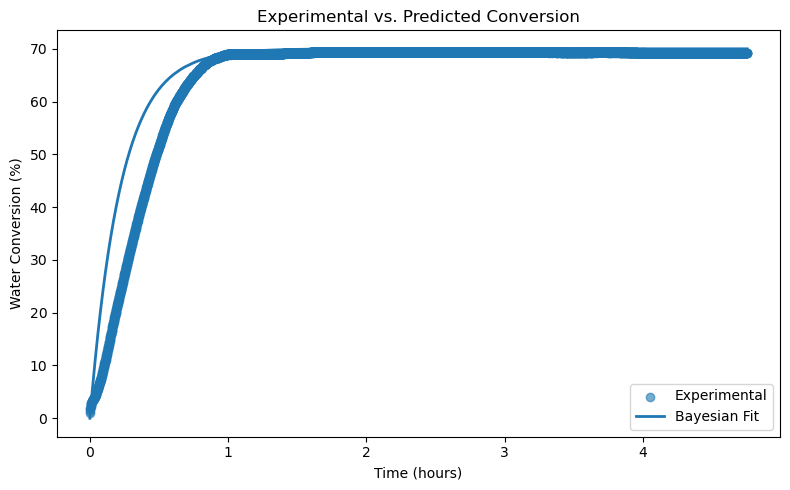

In [16]:
# ─── 12. EXPERIMENTAL vs. PREDICTED CURVE ────────────────────────────────────
y_pred_full = predict_np(
    means["p"], means["q"], means["r"], means["s"],
    DF_full, t_full
)
idx = np.argsort(t_full)
plt.figure(figsize=(8,5))
plt.scatter(t_full, nexp_full, alpha=0.6, label='Experimental')
plt.plot(t_full[idx], y_pred_full[idx], lw=2, label='Bayesian Fit')
plt.xlabel('Time (hours)')
plt.ylabel('Water Conversion (%)')
plt.title('Experimental vs. Predicted Conversion')
plt.legend()
plt.tight_layout()
plt.show()